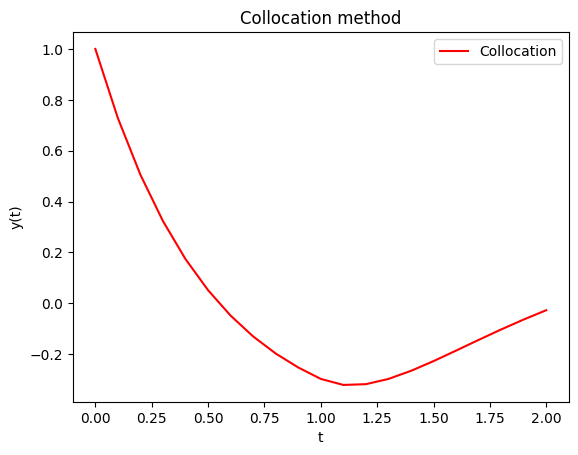

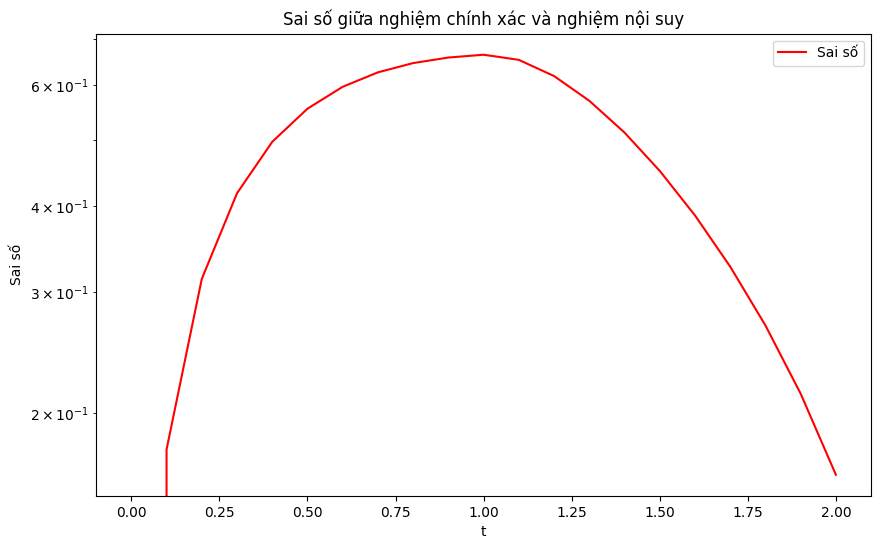

In [5]:
from doan1_dongian.lib_collocation import *
import numpy as np
import matplotlib.pyplot as plt
# hàm np.atleast_1d sẽ trả về một mảng có ít nhất 1 chiều
def f(t, y, y_delay):
    y = np.atleast_1d(y)
    y_delay = np.atleast_1d(y_delay)
    return -2*y -y_delay
def tau(t, y):
    return 1.0
def phi(t):
    return np.atleast_1d(np.array([1.0]))
def y_exact(t):
    return np.exp(-t)
t0 = 0
tf = 2
h0 = 0.1
tol = 1e-6
# sau này sẽ thêm các hàm ước lượng Lipchitz sau
L_f_u = 0.0
L_f_v = 1.0
L_tau_y = 0.0

ts, ys = solve_dde_collocation_adaptive(f, tau, phi, t0, tf, h0,
                                              method_name='gauss', s=2, tol=tol,
                                              L_f_u=L_f_u, L_f_v=L_f_v, L_tau_y=L_tau_y,
                                              h_min=1e-6, h_max=0.1)
plt.plot(ts, ys, 'r-', label='Collocation')
plt.title('Collocation method')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
def compute_error(ts, ys):
    return np.abs(ys[:, 0] - y_exact(ts))
def plot_error(ts, errors):
        plt.figure(figsize=(10, 6))
        plt.plot(ts, errors, 'r-', label='Sai số')
        plt.xlabel('t')
        plt.ylabel('Sai số')
        plt.yscale('log')
        plt.title("Sai số giữa nghiệm chính xác và nghiệm nội suy")
        plt.legend()
        plt.show()
errors = compute_error(ts, ys)
plot_error(ts, errors)



In [6]:
len(ts)

21

21


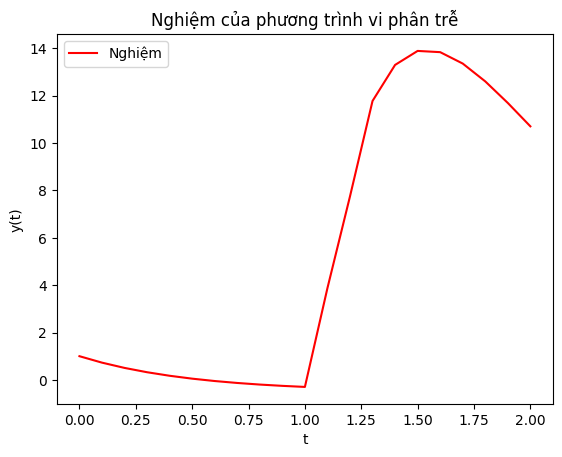

In [7]:
import numpy as np
import matplotlib.pyplot as plt
class NCEFehlbergDDE:
    def __init__(self, f, phi, tau, t0, tf, h):
        """
        f:      function f(t, y, y_delay)
        phi:    history function φ(t) for t <= t0
        tau:    delay function τ(t, y)
        t0,tf:  thời điểm bắt đầu và kết thúc
        h:      bước cố định
        """
        self.f, self.phi, self.tau = f, phi, tau
        self.t0, self.tf, self.h = t0, tf, h

        # --- Butcher coefficients của Fehlberg RKF45 (6-stage) ---
        self.c = [0.0, 1/4, 3/8, 12/13, 1.0, 1/2]
        self.A = [
            [],
            [1/4],
            [3/32,        9/32],
            [1932/2197,  -7200/2197,   7296/2197],
            [439/216,     -8.0,        3680/513,    -845/4104],
            [-8/27,        2.0,       -3544/2565,    1859/4104,  -11/40]
        ]
        # 4th‑order weights (để cập nhật y_{n+1})
        self.b4 = [25/216, 0.0, 1408/2565, 2197/4104, -1/5, 0.0]

        # --- Các đa thức B_i(θ) cho continuous extension ---
        def B1(θ):
            return (θ/1080) * (-41600*θ**5 + 152160*θ**4 - 217950*θ**3
                               + 155300*θ**2 - 58050*θ + 1080)
        def B2(θ):
            return (320*θ**2/1575) * (20800*θ**4 - 69840*θ**3
                                     + 87150*θ**2 - 48600*θ + 1080)
        def B3(θ):
            return (10240*θ**2/12825) * (-10400*θ**4 + 33360*θ**3
                                        - 38850*θ**2 + 19400*θ - 360)
        def B4(θ):
            return (371293*θ**2/7900200) * (-3200*θ**4 + 8160*θ**3
                                           - 7350*θ**2 + 2900*θ - 45)
        def B5(θ):
            return (θ**2/450) * (41600*θ**4 - 102240*θ**3
                                 + 90150*θ**2 - 35100*θ + 540)
        def B6(θ):
            return (2*θ**2/33) * (8320*θ**4 - 25440*θ**3
                                 + 27690*θ**2 - 12600*θ + 216)
        self.B = [B1, B2, B3, B4, B5, B6]

        # Lịch sử để nội suy: mỗi phần tử là (t_n, y_n, ext_fn)
        self.history = []

    def _interp(self, tq):
        """
        Nội suy y tại tq:
        - nếu tq <= t0: trả về φ(tq)
        - khác: tìm bước n sao cho tq in [t_n, t_n+h] rồi dùng ext_fn
        """
        if tq <= self.t0:
            return self.phi(tq)
        for (tn, yn, ext_fn) in reversed(self.history):
            if tn <= tq <= tn + self.h:
                θ = (tq - tn) / self.h
                return ext_fn(θ)
        # Nếu nằm ngoài history, trả giá trị cuối
        return self.history[-1][1]

    def solve(self):
        ts = [self.t0]
        ys = [ self.phi(self.t0) ]

        N = int(np.ceil((self.tf - self.t0) / self.h))
        for _ in range(N):
            tn, yn = ts[-1], ys[-1]

            # 1) Tính K1..K6
            Ks = []
            for i in range(6):
                ti = tn + self.c[i]*self.h
                yi = yn + self.h * sum(self.A[i][j]*Ks[j] for j in range(i))
                # đánh giá y_delay
                t_delay = ti - self.tau(ti, yi)
                y_delay = self._interp(t_delay)
                Ki = self.f(ti, yi, y_delay)
                Ks.append(Ki)

            # 2) Cập nhật y_{n+1} theo b4
            y_np1 = yn + self.h * sum(self.b4[i]*Ks[i] for i in range(6))
            t_np1 = tn + self.h

            # 3) Xây hàm nội suy ext_fn trên [tn, tn+h]
            def make_ext(yn, Ks):
                return lambda θ: yn + self.h * sum(self.B[i](θ)*Ks[i] for i in range(6))

            ext_fn = make_ext(yn, Ks)
            self.history.append((tn, yn, ext_fn))

            ts.append(t_np1)
            ys.append(y_np1)

        return np.array(ts), np.array(ys)


# === Ví dụ sử dụng ===

if __name__ == "__main__":
    def phi(t): 
        return 1.0

    def tau(t, y): 
        return 1.0

    def f(t, y, y_delay): 
        return -2*y -y_delay

    solver = NCEFehlbergDDE(
        f=f,
        phi=phi,
        tau=tau,
        t0=0.0,
        tf=2.0,
        h=0.1
    )

    ts, ys = solver.solve()
    # for t, y in zip(ts, ys):
    #     print(f"t={t:.2f}, y={y:.6f}")
    print(len(ts))
    # Vẽ đồ thị nghiệm
    plt.plot(ts, ys, 'r-', label='Nghiệm')
    plt.title('Nghiệm của phương trình vi phân trễ')
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.legend()
